<a href="https://colab.research.google.com/github/m-hopwood/PRA3024-Big-Data/blob/main/Copy_of_GW_tutorial_2_detector_noise_PSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GW tutorial 2: Detector noise and GW150914

Author: Melissa Lopez

Email: m.lopez@uu.nl

Note that we are importing some packages to be able to read the data.

In [ ]:
!pip install pycbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [115]:
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd
import pylab
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

In the previous part we have seen the detector response to gravitational waves (GW). Currently, we have three ground-based detectors: LIGO Hanford (H1), LIGO Livingston (L1) and Virgo (V1). But what does the data actually look like?

To answer this question we are going to take a look at the first detection: **GW150914**. Let's load the data from L1

In [ ]:
m = Merger('GW150914')
ifo = 'L1'
data = m.strain(ifo)

**Exercise 1:** We can see that this object is a PyCBC timeseries, and as such you can check what their atributes are (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#module-pycbc.types.timeseries)). Let's check some of them.

- How much is the duration of the time series?

- How much is its sampling rate?

- How many data points does it have?

- How much is $\Delta_{f}$ and $\Delta_{t}$? Can you find a relation between these and the number of data points?

_Hint:_ $\Delta_{f} = 1/duration$ and  $\Delta_{t} = 1/sample\_rate$

In [ ]:
print("number of data points is:", len(data.sample_times))
print("the sampling rate is:", data.sample_rate)
print("the duration is:", data.duration)
print("the delta f is:", data.delta_f)
print("the delta t is:", data.delta_t)
print("delta f * no. of data points = sampling rate: 0.03125*131072=4096")
print("delta t * no. of data points = duration: 0.000244*131072=31.98")
print("duration * sampling rate = no. of data points")

number of data points is: 131072
the sampling rate is: 4096.0
the duration is: 32.0
the delta f is: 0.03125
the delta t is: 0.000244140625
delta f * no. of data points = sampling rate: 0.03125*131072=4096
delta t * no. of data points = duration: 0.000244*131072=31.98
duration * sampling rate = no. of data points


In [ ]:
print(f"Duration is{data.duration} s")
print(f"Sampling rate is {data.sample_rate} Hz")
print(f"Shape (no. of data points) is {data.shape[0]}")

N = 1/(data.delta_t * data.delta_f)
N, data.shape[0]

Duration is32.0 s
Sampling rate is 4096.0 Hz
Shape (no. of data points) is 131072


(131072.0, 131072)

The previous magnitudes are key parameters of the timeseries. Now, let's plot the actual data to see what it looks like.

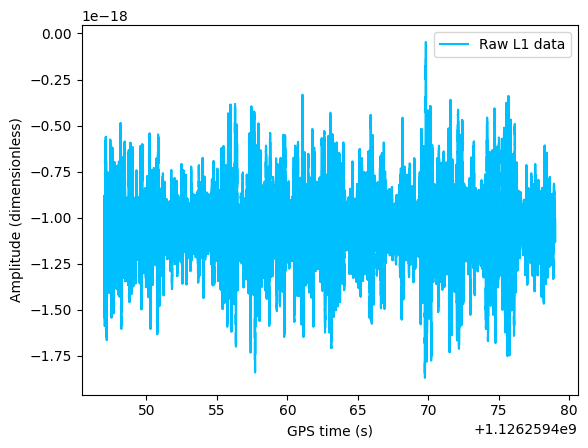

In [116]:
plt.plot(data.sample_times, data, label='Raw L1 data', color='deepskyblue')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

In GW we use the GPS time to determine at what time the GW signals reached Earth. You can see that the amplitude of this data is super small, $\mathcal{O}(10^{-18})$! GW interferometers are able to detect a change in distance of ~1/10,000th the size of a proton.

But, where is GW190514? We cannot see it (yet) as there are many different contributions from the detector. The detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design.

**Exercise 2**: Estimate the PSD of the data using `filter_psd` (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.filter_psd)) and plot it. Limit your plot according to the minimum frequency (say, 1 Hz) and  the Nyquist frequency.

_Hint_: Note that the PSD is a frequency series.

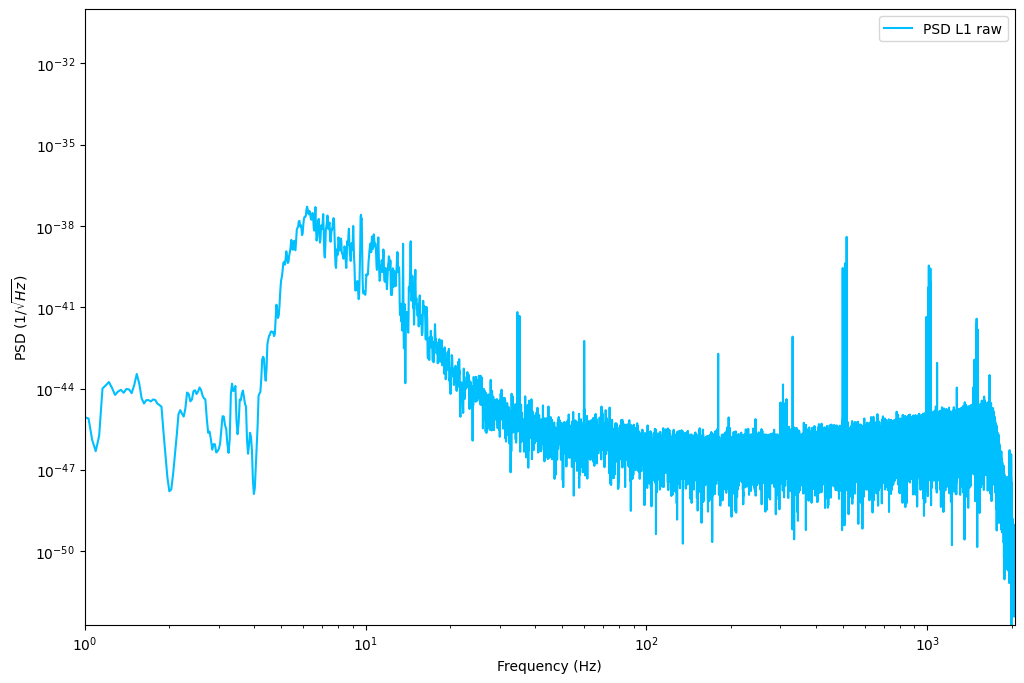

In [126]:
## setting the flow frequency cutoff equal to 1
flow = 1

## estimating the psd of the raw data
filter = data.filter_psd(data.duration, data.delta_f, flow)

## plotting the estimated psd for the raw data
fig1 = plt.figure(figsize=(12,8))
ax1 = fig1.add_subplot(1,1,1)
plt.loglog(np.arange(len(filter)) * data.delta_f, filter, label="PSD L1 raw", color="deepskyblue")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel(r"PSD ($1/\sqrt{Hz}$)")
ax1.set_xlim(10**0, data.sample_rate / 2)
ax1.set_ylim(min(y), 10**-30)
ax1.legend()

plt.show()

The PSD shows us what are the different contributions of the detector noise.
While we computed the PSD from 1 Hz, you can see that there is a weird behaviour for frequencies < 5 Hz. This is because the detector is not calibrated at these frequencies, so our analysis needs to start at higher frequencies. For current ground based detectors, we usually start at 10 Hz or higher, depending on the source.

GW signals are tiny, so with this much noise we won't be able to see GW150914. To "flatten" all frequency contributions we whiten the data.

**Exercise 3:** We can whiten the data with [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.whiten) function. Use `segment_duration = 4` and `max_filter_duration=4`.

- Plot the whitened data next to the raw detector noise. What differences can you see?

- Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?


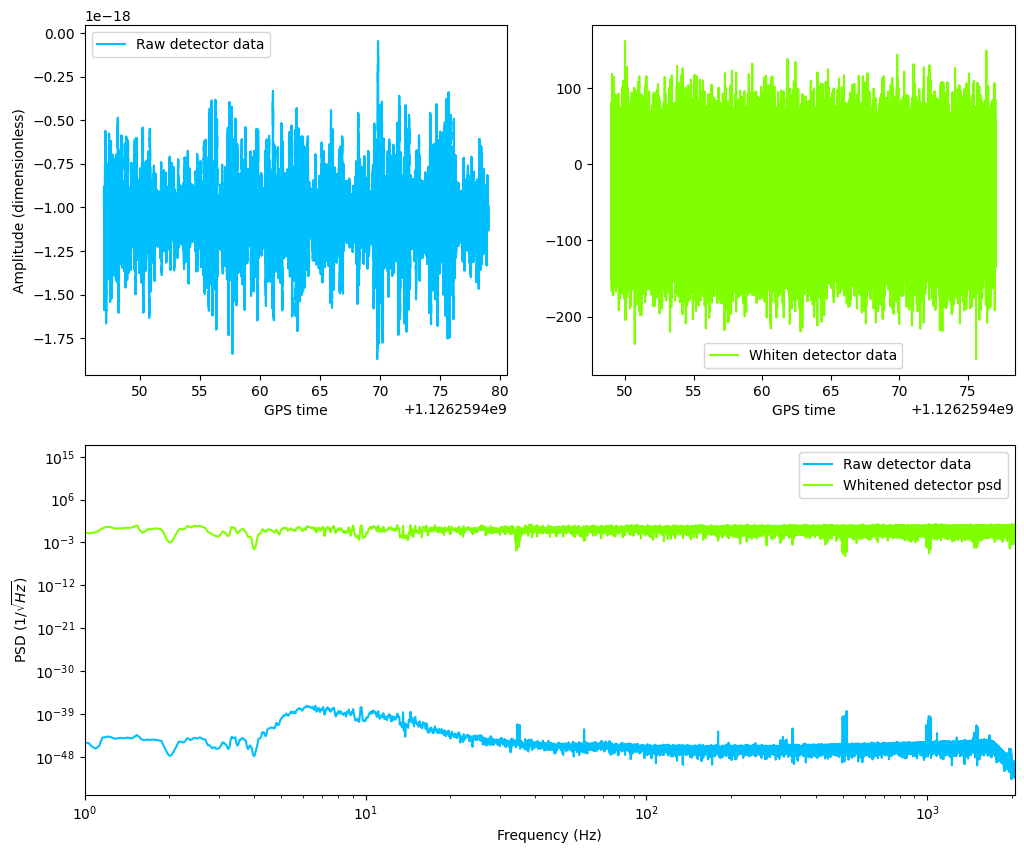

In [127]:
## setting the low frequency cutoff equal to 1
flow = 1

## whitening the data and estimating the psd of the whitened data
whiten_data = data.whiten(segment_duration = 4, max_filter_duration = 4)
psd_whiten = whiten_data.filter_psd(whiten_data.duration, whiten_data.delta_f, flow)

## creating a new figure and grid spec for subplots
fig2 = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

## plotting the amplitude against GPS time for the raw and whitened data
ax2 = fig2.add_subplot(gs[0, 0])
ax2.plot(data.sample_times, data, label = "Raw detector data", color = "deepskyblue")
ax2.set_xlabel("GPS time")
ax2.set_ylabel("Amplitude (dimensionless)")
ax2.legend()

ax3 = fig2.add_subplot(gs[0, 1])
ax3.plot(whiten_data.sample_times, whiten_data, label="Whiten detector data", color = "chartreuse")
ax3.set_xlabel("GPS time")
ax3.legend()

plt.tight_layout

## plotting the estimated psd of both the raw and whitened data
ax4 = fig2.add_subplot(gs[1, :])
ax4.loglog(filter.get_sample_frequencies(), filter, label="Raw detector data", color="deepskyblue")
ax4.loglog(psd_whiten.get_sample_frequencies(), psd_whiten, label="Whitened detector psd", color="chartreuse")
ax4.set_xlabel("Frequency (Hz)")
ax4.set_ylabel(r"PSD ($1/\sqrt{Hz}$)")
ax4.set_xlim(10**0, data.sample_rate / 2)
ax4.legend()

plt.show()

Now all frequency contributions are at the same level, as we can see from the PSD. However, GW150914 is still hidden in the data.


**Exercise 4:** We can apply a [low pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.lowpass_fir) and a [high pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.highpass_fir) to limit the frequency of the data. The low pass filters above 250 Hz (order=512) and the high pass filters below 30 Hz (order=512).

- Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?

- Plot the bandpassed data [cropping](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.crop) 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

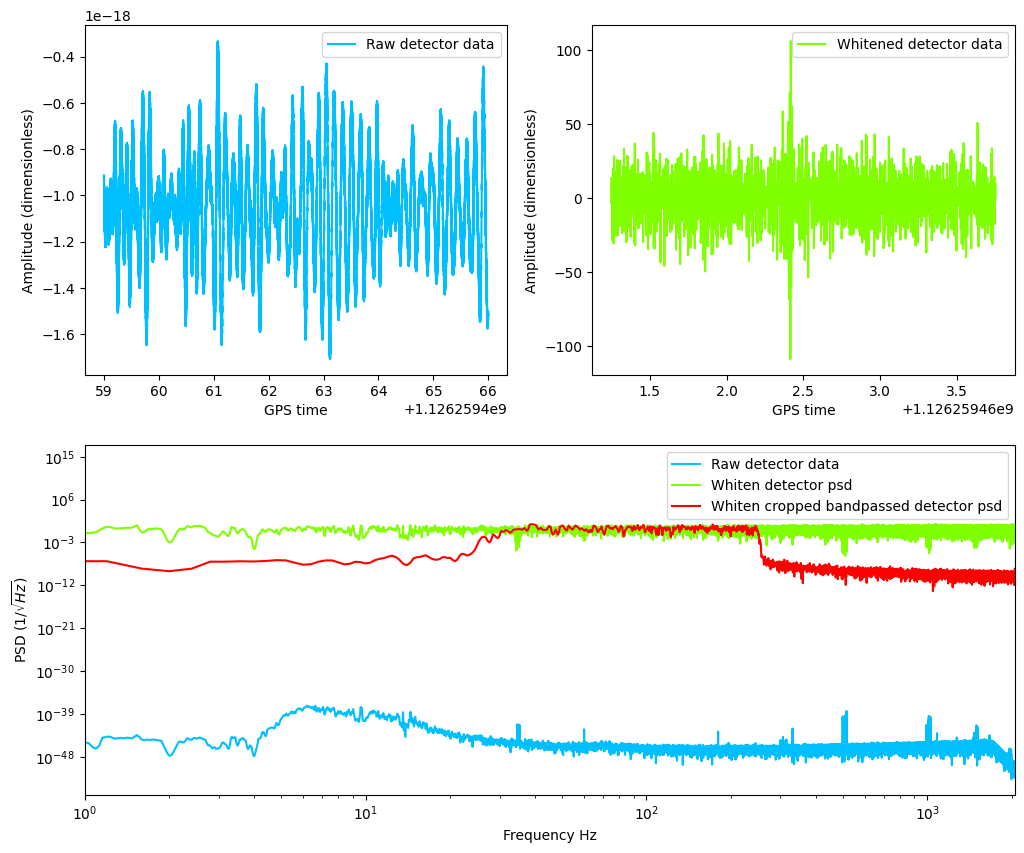

In [128]:
## setting the low frequency cutoff equal to 1
flow = 1

## passing the whitened data through the high and low pass filters
whiten_band_data = whiten_data.highpass_fir(frequency = 30, order = 512); whiten_band_data = whiten_data.lowpass_fir(frequency = 250, order = 512)

## cropping the whitened data and passing through the high and low pass filters
whiten_crop = whiten_data.crop(left = 12, right = 13)
whiten_band_crop = whiten_crop.highpass_fir(frequency = 30, order = 512); whiten_band_crop = whiten_band_crop.lowpass_fir(frequency = 250, order = 512)

## cropping the raw data
data_crop = data.crop(left = 12, right = 13)

## estimating the psd of the bandpassed data
psd_whiten_band = whiten_band_data.filter_psd(whiten_band_data.duration, whiten_band_data.delta_f, flow)
psd_whiten_band_crop = whiten_band_crop.filter_psd(whiten_band_crop.duration, whiten_band_crop.delta_f, flow)

## creating a new figure and grid spec for subplots
fig3 = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

## plotting the amplitude against GPS time for the cropped data, both raw and whitened (in separate subplots)
ax5 = fig3.add_subplot(gs[0, 0])
ax5.plot(data_crop.sample_times, data_crop, label="Raw detector data", color = "deepskyblue")
ax5.set_xlabel("GPS time")
ax5.set_ylabel("Amplitude (dimensionless)")
ax5.legend()

ax6 = fig3.add_subplot(gs[0, 1])
ax6.plot(whiten_band_crop.sample_times, whiten_band_crop, label = "Whitened detector data", color = "chartreuse")
ax6.set_xlabel("GPS time")
ax6.set_ylabel("Amplitude (dimensionless)")
ax6.legend()

## plotting the estimated psd for the raw data, the whitened bandpassed data, and the cropped whitened bandpassed data
ax7 = fig3.add_subplot(gs[1, :])
ax7.loglog(filter.get_sample_frequencies(), filter, label="Raw detector data", color="deepskyblue")
ax7.loglog(psd_whiten.get_sample_frequencies(), psd_whiten, label="Whiten detector psd", color="chartreuse")
ax7.loglog(psd_whiten_band_crop.get_sample_frequencies(), psd_whiten_band_crop, label="Whiten cropped bandpassed detector psd", color="red")
ax7.set_xlabel("Frequency Hz")
ax7.set_ylabel(r"PSD ($1/\sqrt{Hz}$)")
ax7.set_xlim(10**0, data.sample_rate / 2)
ax7.legend()

plt.show()

**Exercise 5:** Last but not least, we generate a spectrogram (time-frequency representation) using [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.qtransform) function.

_Hint_: logfsteps=200, qrange=(110, 110), frange=(20, 512), vmax=3.5 as it is standard

In [ ]:
spec = whiten_band_crop.qtransform(logfsteps = 200, frange = (20, 512), qrange = (110, 110))

In [ ]:
times, frequencies, power = whiten_data.qtransform(delta_t = whiten_data.delta_t, logfsteps = 200, frange = (20, 512), qrange = (110, 110))
fig4 = plt.figure(figsize=(12,6))
ax8 = fig4.add_subplot(1,1,1)
cm = plt.cm.get_cmap('plasma')

ax8.plot(, cmap=cm)
ax8.set_xlabel("Time s")
ax8.set_ylabel("Frequency Hz")
ax8.legend()

cbar = plt.colorbar()
cbar.set_label("")

plt.show()

In [105]:
spec_white_band_crop = whiten_band_crop.qtransform( logfsteps = 200, frange = (20,512), qrange = (110,110))
# whiten and bpad data

fig4 = plt.figure(figsize=(12,6))
ax8 = fig4.add_subplot(1,1,1)
ax8.plot(spec_white_band_crop.sample_times, spec_white_band_crop.get_sample_frequencies, label="Whitened bandpassed cropped", color="black")
ax8.set_xlabel("Time s")
ax8.set_ylabel("Frequency Hz")
ax8.legend()

plt.show()

ValueError: x must be strictly increasing

As we have seen, the detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. Let's see how the detectors will improve in the next observing runs.

**Bonus track:** From the `sensitivity_curves` folder [load](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.read.from_txt) the PSD s:

- Third observing run of H1: `aligo_O3actual_H1.txt`
- Third observing run of L1: `aligo_O3actual_L1.txt`
- Third observing run of V1: `avirgo_O3actual.txt`
- Simulated fourth observing run of LIGO: `aligo_O4high.txt`

Note that these PSDs are from [LIGO public website](https://dcc.ligo.org/ligo-t2000012/public). Also read the PSD of [Einstein Telescope](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.EinsteinTelescopeP1600143) (ET) and [Cosmic Explorer](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.CosmicExplorerP1600143) (CE)

Plot all these PSDs. What can you say about ET and CE improvements?

_Hint_: Minimum frequency is 10 Hz, sampling rate 8192 Hz and duration is 16s.


Good job! This is the end of the second part. Maybe you can go for a break?